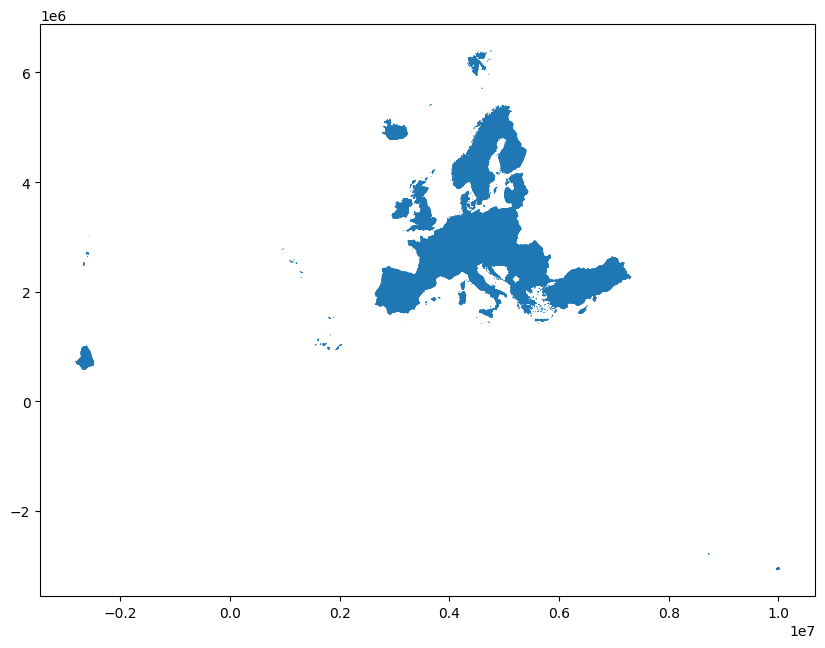

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Download the shapefile for Europe
path = "C:\\Users\\Juliu\\Downloads\\NUTS_RG_20M_2021_3035.shp\\NUTS_RG_20M_2021_3035.shp"
europe = gpd.read_file(path)

# only 

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
europe.plot(ax=ax)
plt.show()

For som reason Bosnia Herzigovina and Kosovo are missing

In [2]:
europe

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483..."
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
4,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
...,...,...,...,...,...,...,...,...,...,...
2005,TRC21,3,TR,Şanlıurfa,Şanlıurfa,4.0,2,3,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,3,TR,Diyarbakır,Diyarbakır,4.0,2,3,TRC22,"POLYGON ((6989716.599 2273670.524, 6982786.486..."
2007,NO0B2,3,NO,Svalbard,Svalbard,3.0,3,1,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."
2008,NO0B,2,NO,Jan Mayen and Svalbard,Jan Mayen and Svalbard,NaN,0,0,NO0B,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [3]:
# exlude french overseas territories as they only have limited coverage
overseas = ["FRY10", "FRY20", "FRY30", "FRY40", "FRY50"]
europe = europe[~europe["NUTS_ID"].isin(overseas)]

In [4]:
european_regions = europe[europe["LEVL_CODE"]==3]

<Axes: >

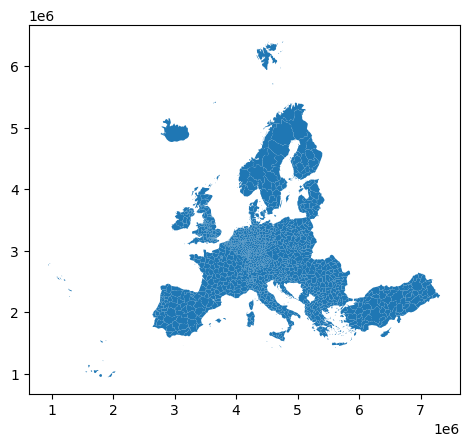

In [5]:
european_regions.plot()

In [6]:
european_regions = european_regions.dissolve()

In [104]:
import shapely
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle
import contextily as ctx

In [8]:
from tqdm import tqdm

In [159]:
xmin, ymin, xmax, ymax = european_regions.total_bounds

length = 50000
wide = 50000

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in tqdm(cols[:-1]):
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

100%|██████████| 128/128 [00:00<00:00, 484.46it/s]


In [160]:
grid = gpd.GeoDataFrame({'geometry':polygons}, crs=european_regions.crs)

In [161]:
europe_grid = gpd.sjoin(grid, europe, how='inner', predicate='intersects')

In [162]:
# remove duplicate gemoetries
europe_grid = europe_grid.drop_duplicates(subset=['geometry'])

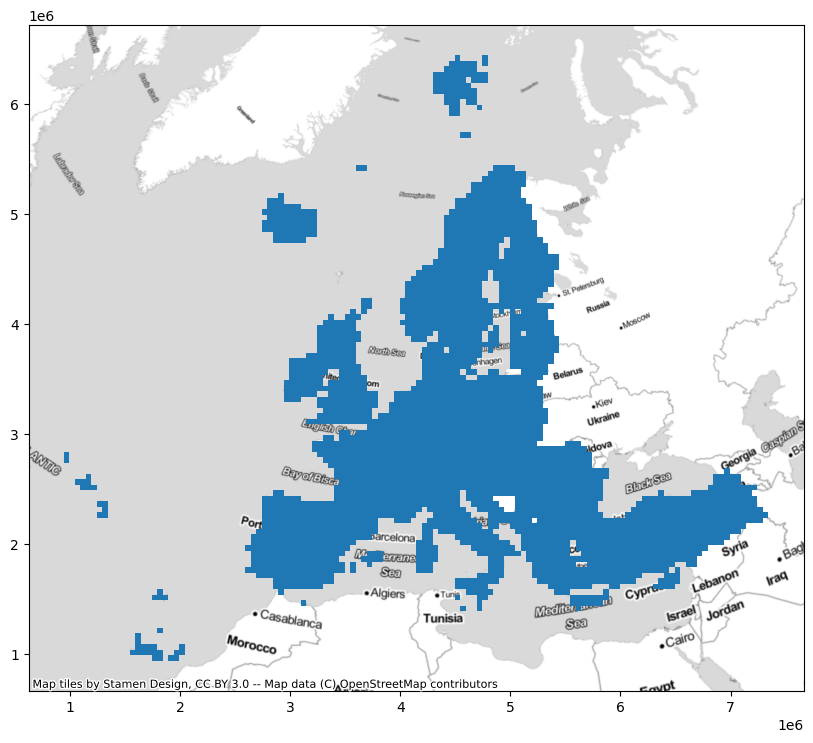

In [163]:
# plot europegrid with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
europe_grid.plot(ax=ax)
ctx.add_basemap(ax, crs=europe_grid.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()

In [164]:
europe_grid.to_file("shapefiles/50k/europe_grid_50k.shp")

C:\Users\Juliu\AppData\Local\Temp\ipykernel_16828\1863934747.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  europe_grid.to_file("shapefiles/50k/europe_grid_50k.shp")


In [187]:
europe_grid.reset_index(inplace=True)

In [188]:
def random_point(polygon):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    return Point(x, y)

In [191]:
# create an empty list to store the random points
points = []
num_points = 20

# loop through each geometry in the dataframe
for geom in europe_grid['geometry']:
    for i in range(num_points):
        # generate a random point within the geometry
        point = random_point(geom)
        # add the point to the list
        points.append(point)

# create a new geopandas dataframe with the random points
points_gdf = gpd.GeoDataFrame(geometry=points, crs=europe_grid.crs)

In [192]:
points_gdf.head()

,geometry
0,POINT (988010.627 2776678.879)
1,POINT (946523.785 2790234.193)
2,POINT (957498.525 2745632.344)
3,POINT (962029.501 2752291.248)
4,POINT (987145.882 2788803.776)


In [193]:
# convert to real world coordinates
points_gdf_wgs84 = points_gdf.to_crs(epsg=4326)

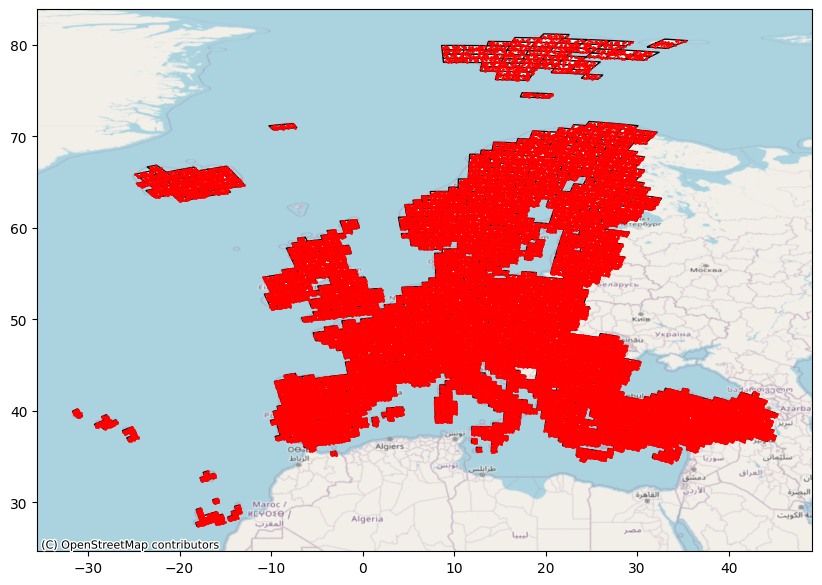

In [195]:
# plot the points with basemap
fig, ax = plt.subplots(figsize=(10, 10))
europe_grid.to_crs(epsg=4326).plot(ax=ax, color='white', edgecolor='black')
points_gdf_wgs84.plot(ax=ax, color='red', markersize=1)
ctx.add_basemap(ax, crs=points_gdf_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

In [196]:
points_gdf_wgs84.head()

,geometry
0,POINT (-30.85889 39.67737)
1,POINT (-31.36493 39.58225)
2,POINT (-31.00366 39.29773)
3,POINT (-30.99351 39.36963)
4,POINT (-30.93527 39.76503)


In [197]:
points_gdf_wgs84.shape

(61120, 1)

In [ ]:
# coordinates are in lon/lat format in our dataframe

In [ ]:
# need function to call google api and scrape images from coordinates